# DBSCAN Clustering

In [1]:
#Import Related Libraries
import pandas as pd
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [2]:
#Load the datset of customers which is saved as csv file
df = pd.read_csv('pick_and_del.csv')

In [3]:
df.head()

,CUST NO.,XCOORD.,YCOORD.,DEMAND,READY TIME,DUE DATE,SERVICE TIME,TYPE
0,2407,151.186935,-33.934121,1,25200,72000,900,pickup
1,67,150.998430,-33.920350,1,23400,32400,900,pickup
2,122,151.164240,-33.923950,1,50400,64800,900,pickup
3,145,151.198590,-33.903630,1,54000,61200,900,pickup
4,149,151.216090,-33.882890,1,43200,57600,900,pickup


In [4]:
#Check Number of Customers
print(len(df))

190


In [5]:
#Conver latitude and Longitude of customers to array
coords = df[['YCOORD.', 'XCOORD.']].to_numpy()

In [6]:
#inorder to start the labels from 1 
#labels in DBSCAN starts from -1 which is cluster of outliers
def normalize_cluster_labels(labels):
    min_value = min(labels)
    if (min_value < 0):
         labels = labels + 1
    return labels

Inputs of the models

In [7]:
#Maximum number of customers in each cluster
max_cluster_size_const = 40
#Minimum number of customers in each cluster
min_cluster_size_const = 10


km_per_radian = 6371.0088 #km/rad

DBSCAN Algorithm

In [8]:
def DBSCAN_AL_simple(coords, eps):
    global clusters
    km_per_radian = 6371.0088 #km/rad
    db = DBSCAN(eps=eps/(km_per_radian*10), min_samples=min_cluster_size_const, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    cluster_labels_nn = normalize_cluster_labels(cluster_labels)
    num_clusters = len(set(cluster_labels_nn))
    clusters = pd.Series([coords[cluster_labels_nn == n] for n in range(num_clusters)])
    return clusters

Find the best Epsilon for DBSCAN

In [9]:
#This function calculates distance between two gps points

import math

def haversine(coord1, coord2):
    R =6371.0088  # Earth radius in km
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [10]:
c_list = df['CUST NO.'].tolist() # list of customers inorder to add them as the key of dictionary

#make a dictionary of customers' location (lat & lon)
customerloc ={}

for j in c_list:
    customerloc[j] = (df.iloc[c_list.index(j), 2] , df.iloc[c_list.index(j), 1])


In [11]:
#Create distance Matrix

matrix = []

for i in range(len(list(customerloc.values()))):
    # Append an empty sublist inside the list
    matrix.append([])
    
    m = list(customerloc.values())[i][0], list(customerloc.values())[i][1]
    
    for c_id, coord in customerloc.items():
        distance = haversine(m , coord)
        matrix[i].append(distance)    

In [12]:
max_lst = []
min_lst = []


# Find the second smallest value of a list as the smallest is 0 (distance between the point and itself) in distance matrix

def find_2nd_max(lst):
    lst = [x for x in lst if x != 0.0]
    return min(lst)


# This loop finds the max and min value in each row of distance matrix

for i in range(len(matrix)):
    max_lst.append(max(matrix[i]))
    min_lst.append(find_2nd_max(matrix[i]))

# Find the min and max value of whole gps points

max_dist = max(max_lst)
min_dist = min(min_lst)

    

In [13]:
#Converting min_dist to an integers number
#This requires to be multiplied by the number of decimal values in min distance

# No. of zeros required
n = len(str(min_dist))

# using ljust() adding trailing zero
str_ = '1'
output = str_.ljust(n + len(str_), '0')
output = int(output)

# Finding the best radius trough loop in which clusters are made according to different epsilon 
# between min and max ditsnce
# the computational time for this processing is really high but it is the most accurate way to get the clusters
def best_radius_time_limit(coords):
    global bestradius
    radius_lst = []
    for i in range (int(min_dist*output), int(max_dist*output)):
        D = DBSCAN_AL_simple(coords, i/output)
        radius_lst.append(len(D))
        
    bestradius = radius_lst.index(max(radius_lst))
    return bestradius

In [14]:
# As the eps must be possitive as input of the DBSCAN we try to test eps between 1 and roundup of the max distance
# This takes time as well but worths to be used rather than previous one 

def best_radius(coords):
    global bestradius
    radius_lst = []
    for i in range (1, round(max_dist)):
        D = DBSCAN_AL_simple(coords, i)
        radius_lst.append(len(D))
        
    bestradius = radius_lst.index(max(radius_lst))+1
    return bestradius

Generate Initial Solution

In [15]:
# Generate Initial Solution for the recursive algorithm
# We generate clusters for the first run
D = DBSCAN_AL_simple(coords, best_radius(coords))

In [16]:
D

0    [[-33.9341214, 151.1869349], [-33.92035, 150.9...
1    [[-33.88289, 151.21609], [-33.87761, 151.24476...
2    [[-33.90363, 151.19859], [-33.91238, 151.19703...
dtype: object

Recursive_DBSCAN

In [17]:
done = [] # create a list in which all accpted clusters will be stored
nonempty = D # make a series in which in each itteration we store the new clusters and remove previuos clusters

In [18]:
while len(nonempty):   # while there is no clusters needed to be re-cluster (all clusters all accepted)
    print("size of first nonempty", len(nonempty))
    for i in nonempty:
        if len(i)> max_cluster_size_const:
            nonempty = nonempty.drop(list(nonempty).index(i))
            nonempty = nonempty.reset_index(drop=True)
            G =  DBSCAN_AL_simple(i, best_radius(i))
            
            # There are some clusters that won't be reculstered due to the eps limitation mentioned before
            # We count this points as outlier which will be handled in next part
            if (len(G)) != 1:
                for g in G:
                    print("size of G", len(g))
                nonempty = pd.concat([nonempty, G], ignore_index = True)
                print("size of nonempty_after", len(nonempty))
                
            else:
                done.append(i)

                
        else:
            done.append(i)
            nonempty = nonempty.drop(list(nonempty).index(i))
            nonempty = nonempty.reset_index(drop=True)

size of first nonempty 3
size of G 124
size of G 15
size of G 10
size of G 11
size of nonempty_after 6
size of first nonempty 4
size of G 87
size of G 13
size of G 14
size of G 10
size of nonempty_after 7
size of first nonempty 4
size of G 53
size of G 14
size of G 14
size of G 6
size of nonempty_after 7
size of first nonempty 4
size of G 23
size of G 10
size of G 10
size of G 10
size of nonempty_after 7
size of first nonempty 4


In [19]:
# Check wether all the points are clustered

sumation = 0
for i in range(len(done)):
    sumation += len(done[i])


print(sumation)
print(sumation == len(df))

190
True


In [20]:
# Check the number of points in each cluster

lst_len_clusters = []
for i in range(len(done)):
    lst_len_clusters.append(len(done[i]))

In [21]:
print(lst_len_clusters)

[14, 16, 15, 10, 11, 13, 14, 10, 14, 14, 6, 23, 10, 10, 10]


In [22]:
# As can be seen there are some clusters that the number of point is less than lower bound and there are some clusters 
# the number of point in them is greater than upper bound.
# all points in these clusters are counted as outliers, so it's time to handle them.

Handling Outliers

In [23]:
# For handling outliers we first make a dataset out of our final_results

In [24]:
# Make dataset for each cluster
# This makes dataframe in loop
d = {}
for name in range(len(done)):
    d[name] = pd.DataFrame(done[name])

In [25]:
# Change the column name
# Add cluster_ID as a new column to our dataframe
for i in range(len(d)):
    d[i].columns = ['y_coord', 'x_coord']
    d[i]['cluster_id'] = list(d.keys())[i]

In [26]:
# Concatanate (join vertically) the dataframes

final_results = pd.DataFrame()
i = 0

while i < len(d):
    final_results = pd.concat([final_results, d[i]], ignore_index=True)
    i += 1

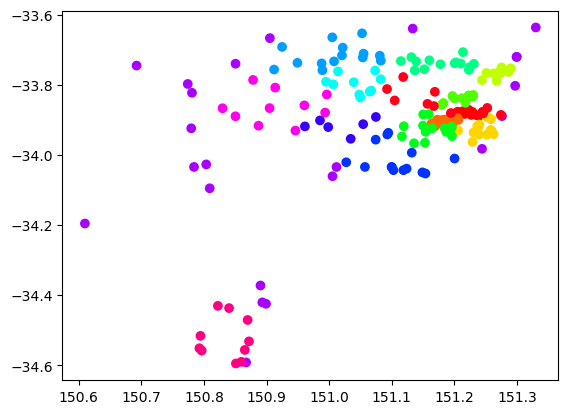

In [27]:
# See the Clusters on the map
plt.scatter(final_results['x_coord'], final_results['y_coord'],c=final_results['cluster_id'], cmap=plt.cm.hsv)

In [28]:
#As they maybe some identical value in the list, their index(cluster_ID) reamins same if we use .index() 
#so this function is defined this function

def indices( mylist, value):
    return [i for i,x in enumerate(mylist) if x==value]

In [29]:
# find the cluster ID of outputs counted as outlier

Outlierts_cluster_ID = []
for i in lst_len_clusters:
    if i > max_cluster_size_const or i < min_cluster_size_const:
        Outlierts_cluster_ID.append(indices( lst_len_clusters, i))
        
# The output of above loop is list of list so we flatten it        
Outlierts_cluster_ID_flt = [item for sublist in Outlierts_cluster_ID for item in sublist]

In [30]:
# This clusters are not accpeted

Outlierts_cluster_ID_flt

[10]

In [31]:
# We exclude these clusters from our datset
final_results_without_outlier = final_results.copy()
for i in Outlierts_cluster_ID_flt:
    final_results_without_outlier = final_results_without_outlier[final_results_without_outlier.cluster_id != i]

In [32]:
# We create a datset of outliers

final_results_outlier = final_results.loc[final_results['cluster_id'].isin(Outlierts_cluster_ID_flt)]  

# For outliers detected by our instinct

In [33]:
# We claclulate the average distance of every customer in a cluster from their own clusters

#claculate cluster center
centers = final_results.groupby(['cluster_id']).mean()
centers = centers.reset_index()

# Retrive unique cluster IDs
cluster_ids = list(set(final_results['cluster_id'].tolist()))

# make dictionary of clusters and their points
points_in_cluster = {}
for i in cluster_ids:
    points_in_cluster[i] = final_results[final_results['cluster_id'] == i]

In [34]:
#This function calculates distance between two gps points

def haversine(coord1, coord2):
    R =6371.0088  # Earth radius in km
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))


In [35]:
# Caculate the distance between each point and their own cluster center cluster

def distance_to_cluster(cluster_center_x_y, dic):
    distance_to_cl= []
    for outliers, coord in dic.items():
        distance = haversine(cluster_center_x_y , coord)
        distance_to_cl.append(distance)
        
    return distance_to_cl

In [36]:
# save Calculation
av_dist = {}
for i in cluster_ids:
    dic = {}
    points_in_cluster[i] = points_in_cluster[i].reset_index()
    for j in range(len(points_in_cluster[i])):
        dic[j] = (points_in_cluster[i].iloc[j,2], points_in_cluster[i].iloc[j,1])

    distance_in_cluster = [] 

    cluster_center_x_y = centers.iloc[cluster_ids.index(i), 2], centers.iloc[cluster_ids.index(i), 1]
    distance_in_cluster.append(distance_to_cluster(cluster_center_x_y, dic))
    #print(distance_in_cluster)
    av_dist[i] = sum(distance_in_cluster[0])/len(points_in_cluster[0])

In [37]:
inst_outlier_cls = []

for i in list(av_dist.keys()):
    if av_dist[i] > 15:
        inst_outlier_cls.append(i)  

In [38]:
inst_outlier_cls

[11]

Text(0, 0.5, 'Y Coordinate')

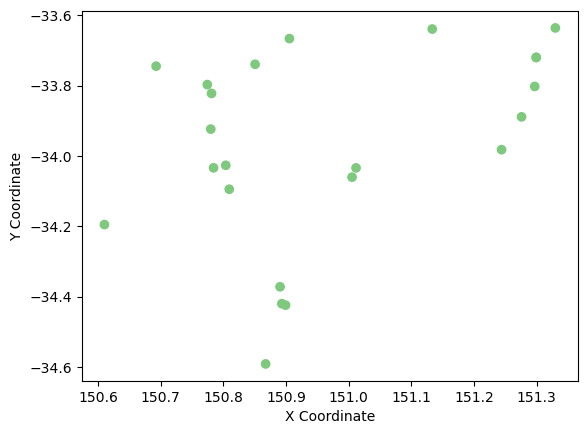

In [39]:
# Check cluster of Outliers

# make datasets of outliers
outlier_df = {}
# colors
clr = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 
       'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r',
       'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 
       'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy',
       'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r']
for i, j in zip(inst_outlier_cls, clr):
    outlier_df[i] = final_results[final_results['cluster_id']==i]
    plt.scatter(outlier_df[i]['x_coord'], outlier_df[i]['y_coord'],c=outlier_df[i]['cluster_id'], cmap=j)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

In [40]:
for i in inst_outlier_cls:
    final_results_outlier = pd.concat([final_results_outlier, outlier_df[i]])

In [41]:
for i in inst_outlier_cls:
    final_results_without_outlier = final_results_without_outlier[final_results_without_outlier['cluster_id']!= 33]

# Till here

In [42]:
print ('Total number of outliers, is:', len(final_results_outlier))

final_results_outlier = final_results_outlier.reset_index()

Total number of outliers, is: 29


In [43]:
# We caclulate the center of each cluster, by clculating the average of x and y coordinate

clusers_center = final_results_without_outlier.groupby(['cluster_id']).mean()

In [44]:
# the index is kept as cluster ID

clusers_center = clusers_center.reset_index()

In [45]:
c_list = final_results_outlier['index'].tolist()

In [46]:
#make a dictionary of outliers

outlier ={}

for j in c_list:
    outlier[j] = (final_results_outlier.iloc[c_list.index(j), 1] , final_results_outlier.iloc[c_list.index(j), 2])

In [47]:
# Caculate the distance between each point and each cluster

def distance_to_cluster(cluster_center_x_y):
    distance_to_cl= []
    for outliers, coord in outlier.items():
        distance = haversine(cluster_center_x_y , coord)
        distance_to_cl.append(distance)
        
    return distance_to_cl

In [48]:
lst_of_distance_from_cluster = []

for i in range(len(clusers_center)):
    cluster_center_x_y = clusers_center.iloc[i, 1], clusers_center.iloc[i, 2]
    lst_of_distance_from_cluster.append(distance_to_cluster(cluster_center_x_y))

In [49]:
len(lst_of_distance_from_cluster)

14

In [50]:
del final_results_outlier['index']

In [51]:
centers_df  = pd.DataFrame(lst_of_distance_from_cluster).transpose()
centers_df.columns = final_results_without_outlier.cluster_id.unique().tolist()

/var/folders/5l/l5lg6hfx2992d_rsbxhvt0wc0000gn/T/ipykernel_86668/962600326.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(clusers_center['x_coord'], clusers_center['y_coord'], cmap=plt.cm.hsv, label='cluster centers')
/var/folders/5l/l5lg6hfx2992d_rsbxhvt0wc0000gn/T/ipykernel_86668/962600326.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(final_results_outlier['x_coord'], final_results_outlier['y_coord'], cmap=plt.cm.hsv, label='outliers')


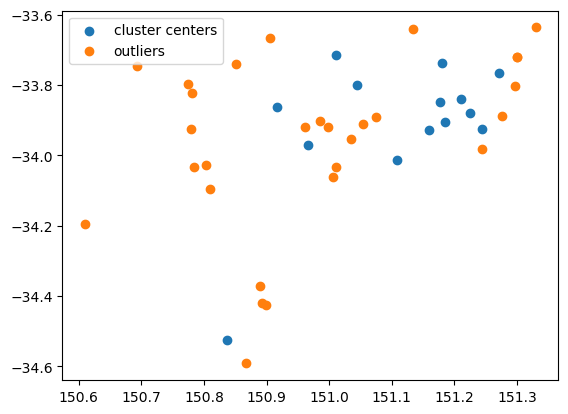

In [52]:
# See the ouliers and the center of accpted clusters

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(clusers_center['x_coord'], clusers_center['y_coord'], cmap=plt.cm.hsv, label='cluster centers')
ax1.scatter(final_results_outlier['x_coord'], final_results_outlier['y_coord'], cmap=plt.cm.hsv, label='outliers')
plt.legend(loc='upper left')

In [53]:
# Now we want to assign the outliers to their nearest cluster

In [54]:
# We extract accepted cluster IDs

index = final_results_without_outlier['cluster_id'].unique()
index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14])

In [55]:
# We generate numbers from 0 to length of number of cluster-1 to have uniform index

index_of_index = np.array([i for i in range(len(index))])
index_of_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [56]:
# We combine the index and generated index to be extracted next

combined_index = np.stack((index_of_index, index), axis=1)

In [57]:
# Check the number of points in each accepted cluster and save them

lst_len_acc_clusters = []
for i in index:
    lst_len_acc_clusters.append(len(final_results_without_outlier[final_results_without_outlier['cluster_id'] == i]))

In [58]:
# Make index for each value of list of cluster lenghts

combined_index_with_size_of_clusters = np.stack((index_of_index, lst_len_acc_clusters), axis=1)
# combined_index_with_size_of_clusters

In [59]:
# We assign the outliers to their nearest cluster while the cluster is filled with max_cluster_size_const no. of customers


new_index_of_outlier = {}
i = 0
while i < len(centers_df):
    
    idx = centers_df.loc[i, :].values.tolist().index(min(centers_df.loc[i, :].values.tolist()))
    
#    initial_idx = combined_index[idx][1]
    
    if combined_index_with_size_of_clusters[idx][1] <= max_cluster_size_const:
        
        new_index_of_outlier[i] = combined_index_with_size_of_clusters[idx][0]
        combined_index_with_size_of_clusters[idx][1] += 1
        i += 1
        
    else:  
        centers_df = centers_df.drop(centers_df.columns[[idx]], axis=1)

In [60]:
# Dictionary to dataframe

dict_to_list = list(new_index_of_outlier.items())
new_cluster_of_outlier = pd.DataFrame(dict_to_list,columns=['index','initial cluster'])
# new_cluster_of_outlier

In [61]:
# Replace the made cluster IDs (index) with their actual value

for i in range(len(new_cluster_of_outlier)):
    new_cluster_of_outlier.iloc[i, 1] = combined_index[new_cluster_of_outlier.iloc[i, 1]][1]

In [62]:
# Add the clusters to the points (lon, lat)

final_results_outlier = final_results_outlier.reset_index().merge(new_cluster_of_outlier, on = ['index'], how = 'left')

del final_results_outlier['index']
del final_results_outlier['cluster_id']

In [63]:
final_results_outlier.columns = ['y_coord', 'x_coord', 'cluster_id']

In [64]:
# Combine accepted clusters with handled outliers

df_final = pd.concat([final_results_without_outlier,final_results_outlier], ignore_index=True)

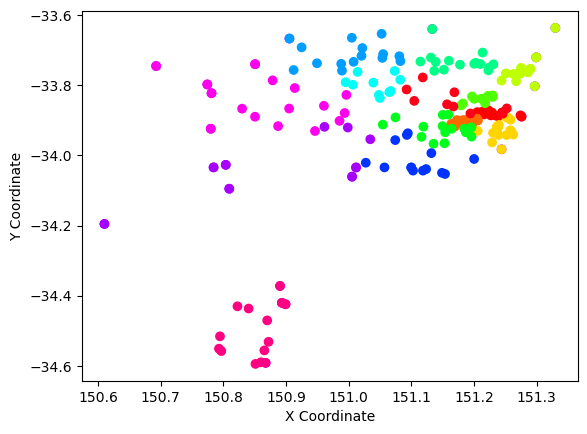

In [65]:
# See Final Clusters on the map and save them
plt.scatter(df_final['x_coord'], df_final['y_coord'],c=df_final['cluster_id'], cmap=plt.cm.hsv)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.savefig("output.png")

In [66]:
# change the column name to be joined

df.columns = ['CUST NO.', 'x_coord', 'y_coord', 'DEMAND', 'READY TIME', 'DUE DATE',
       'SERVICE   TIME', 'TYPE']


data_to_be_saved = pd.merge(df,             # Combine horizontally
                           df_final,
                           on = ['x_coord', 'y_coord'],
                           how = "left").drop_duplicates()

In [67]:
M = max([*set(data_to_be_saved['cluster_id'].tolist())])

# Add shipment

In [68]:
df_shipment = pd.read_csv('shipment.csv')

In [69]:
df_shipment.head(2)

,lon,lat,DEMAND,READYTIME,DUETIME,SERVECETIME,TYPE
0,150.99843,-33.92035,0,28800,32400,900,Shipment Pick up
1,150.89299,-34.42486,1,25200,54000,900,Shipmeng Delivery


In [70]:
df_shipment['cluster_id']= M+100

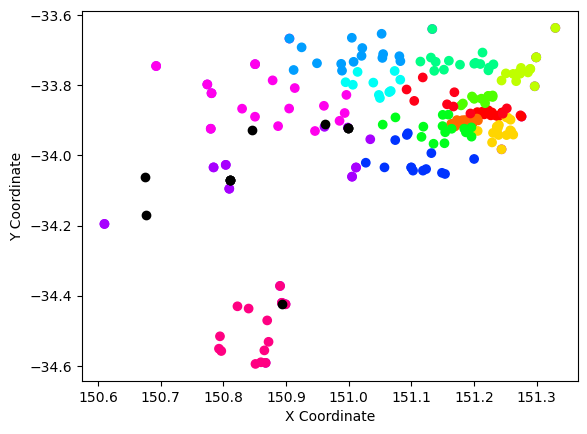

In [71]:
# See Final Clusters on the map and save them
plt.scatter(df_final['x_coord'], df_final['y_coord'],c=df_final['cluster_id'], cmap=plt.cm.hsv)
plt.scatter(df_shipment['lon'], df_shipment['lat'],c='#000000')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.savefig("output.png")

In [72]:
# find final cluster centers

clusers_center = data_to_be_saved.groupby(['cluster_id']).mean()

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
df_shipment = df_shipment.reset_index()

In [ ]:
df_shipment.head(2)

In [ ]:
# See the ouliers and the center of accpted clusters

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(clusers_center['x_coord'], clusers_center['y_coord'], cmap=plt.cm.hsv, label='cluster centers')
ax1.scatter(df_shipment['lon'], df_shipment['lat'], cmap=plt.cm.hsv, label='shipment')
plt.legend(loc='lower right')

In [ ]:
#make a dictionary of shipment Data
c_list = df_shipment['index'].tolist()

outlier ={}

for j in range(df_shipment.shape[0]):
    outlier[j] = (df_shipment.iloc[j, 1] , df_shipment.iloc[j, 2])

In [ ]:
lst_of_distance_from_cluster = []

for i in range(len(clusers_center)):
    cluster_center_x_y = clusers_center.iloc[i, 1], clusers_center.iloc[i, 2]
    lst_of_distance_from_cluster.append(distance_to_cluster(cluster_center_x_y))

In [ ]:
df_shipment.cluster_id

In [ ]:
centers_df  = pd.DataFrame(lst_of_distance_from_cluster).transpose()
centers_df.columns =data_to_be_saved.cluster_id.unique().tolist()

In [ ]:
minvalueIndexLabel = centers_df.idxmin(axis="columns")
minvalueIndexLabel

In [ ]:
df_to_clstr = minvalueIndexLabel.to_frame()
df_to_clstr = df_to_clstr.reset_index()
df_to_clstr.columns = ['point_id', 'minimum_distance_to']

In [ ]:
# convert clomn names to string

clumns_c = centers_df.columns.tolist()
clumns_c = list(map(str, clumns_c)) 
centers_df.columns = clumns_c

In [ ]:
# This loop asign both of the points in 

i = 0
while i < df_to_clstr.shape[0]:
    #print(i)
    if df_to_clstr.iloc[i, 1] != df_to_clstr.iloc[i+1, 1]:
        dist_1 = centers_df.loc[i, str(df_to_clstr.iloc[i, 1])] + centers_df.loc[i+1, str(df_to_clstr.iloc[i, 1])]
        print('d1', dist_1)
        dist_2 = centers_df.loc[i, str(df_to_clstr.iloc[i+1, 1])] + centers_df.loc[i+1, str(df_to_clstr.iloc[i+1, 1])]
        print('d2', dist_2)
        if dist_1 >= dist_2:
            df_to_clstr.iloc[i, 1] = df_to_clstr.iloc[i+1, 1]
        else:
            df_to_clstr.iloc[i+1, 1] = df_to_clstr.iloc[i, 1]
            
        i += 2
    else:
        i += 2   

In [ ]:
del df_shipment['cluster_id']

In [ ]:
df_to_clstr.columns = ['index', 'cluster_id']

In [ ]:
df_shipment_cluster = pd.merge(df_shipment, df_to_clstr, on = 'index', how = 'left' )

In [ ]:
df_shipment_cluster.columns = data_to_be_saved.columns.tolist()

In [ ]:
df_final = pd.concat([data_to_be_saved, df_shipment_cluster], ignore_index = True)

In [ ]:
# See Final Clusters on the map and save them
plt.scatter(df_final['x_coord'], df_final['y_coord'],c=df_final['cluster_id'], cmap=plt.cm.hsv)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.savefig("output.png")

In [ ]:
df_final.to_csv('P&D_clusters.csv')